<a href="https://colab.research.google.com/github/ZiminPark/bandit-reco/blob/master/notebooks/2.%20Likelihood%20Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install recogym

     |████████████████████████████████| 61kB 3.5MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 245kB 21.9MB/s 


# Likelihood-based models

This notebook will outline the likelihood-based approach to training on Bandit feedback.

Although before proceeding, we will study the output of the simulator in a little more detail.

In [2]:
from numpy.random.mtrand import RandomState
from recogym import Configuration
from recogym.agents import Agent
from sklearn.linear_model import LogisticRegression
from recogym import verify_agents
from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args
from recogym.agents import RandomAgent, random_args
from recogym.evaluate_agent import verify_agents, plot_verify_agents

import gym, recogym
from copy import deepcopy
from recogym import env_1_args
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 3]

num_users = 1000

env_1_args['number_of_flips'] = 0
env_1_args['sigma_mu_organic'] = 0.0
env_1_args['sigma_omega'] = 1
env_1_args['random_seed'] = 42
env_1_args['num_products'] = 10
env_1_args['K'] = 5
env_1_args['number_of_flips'] = 5

env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

In [3]:
data = deepcopy(env).generate_logs(num_users)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 1000/1000 [00:24<00:00, 41.17it/s]


# Logistic Regression Model

## Turn Data into Features

Now we are going to build a _Logistic Regression_ model.

The model will predict _the probability of the click_ for the following data:
* _`Views`_ is a total amount of views of a particular _`Product`_ shown during _Organic_ _`Events`_ **before** a _Bandit_ _`Event`_.
* _`Action`_ is a proposed _`Product`_ at a _Bandit_ _`Event`_.

For example, assume that we have _`10`_ products. In _Organic_ _`Events`_ , these products  were shown to a user as follows:

| Product Id | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8  | 9 |
|------------|---|---|---|---|---|---|---|---|----|---|
| Views      | 0 | 0 | 0 | 7 | 0 | 0 | 0 | 8 | 11 | 0 |

When we want to know the probability of the click for _`Product`_ = _`8`_ with available amounts of _`Views`_ , the input data for the model will be:

$v = $_`0 0 0 7 0 0 0 8 11 0`_ and _**`8`**_

The first `10` numbers are _`Views`_ of _`Products`_ (see above), the latest one is the _`Action`_.

We will try to predict: $\mathbb{P}(C|P=p, V)$ that is the probability of the click for a _`Product`_ $p$, provided that we have _`Views`_ $V$.

We will encode _`Action`_ using a one-hot encoding.
In our current example, the _`Action`_ is _`8`_. Thus, it is encoded as:

_$a = $`0 0 0 0 0 0 0 0`_ _**`1`**_ _`0`_

Here,
* Vector of _`Actions`_ has a size that is equal to the _*number of `Products`*_ i.e., _`10`_.
* _`Action`_ _`8`_ is marked as _`1`_ (_`Action`_ starts with _`0`_ ).

Numerically, to fully describe the context $P=p, V$ that mixes the evaluated product and the products seen by the user, we do a Kronecker product of the two vectors $a$ and $v$. 
Namely, the vector used as features is the flattened version of the following $P \times P$ matrix
$$
\begin{pmatrix}
\cdots & 0      & \cdots \\
  & \vdots & \\
\cdots & v & \cdots \\
  & \vdots & \\
\cdots & 0      & \cdots
\end{pmatrix}
\leftarrow \text{ only the line corresponding the the action $p$ is non zero}
$$

In [4]:
from recogym.agents import FeatureProvider

class CountFeatureProvider(FeatureProvider):
    """Feature provider as an abstract class that defines interface of setting/getting features"""

    def __init__(self, config):
        super(CountFeatureProvider, self).__init__(config)
        self.feature_data = np.zeros((self.config.num_products))

    def observe(self, observation):
        """Consider an Organic Event for a particular user"""
        for session in observation.sessions():
            self.feature_data[int(session['v'])] += 1

    def features(self, observation):
        """Provide feature values adjusted to a particular feature set"""
        return self.feature_data

    def reset(self):
        self.feature_data = np.zeros((self.config.num_products))

In [6]:
data

,t,u,z,v,a,c,ps,ps-a
0,0.0,0,organic,0,<NA>,NaN,NaN,None
1,1.0,0,bandit,<NA>,3,0.0,0.1,()
2,2.0,0,bandit,<NA>,4,0.0,0.1,()
3,3.0,0,bandit,<NA>,5,0.0,0.1,()
4,4.0,0,bandit,<NA>,0,0.0,0.1,()
...,...,...,...,...,...,...,...,...
97444,3.0,999,bandit,<NA>,0,0.0,0.1,()
97445,4.0,999,bandit,<NA>,0,0.0,0.1,()
97446,5.0,999,bandit,<NA>,0,0.0,0.1,()
97447,6.0,999,bandit,<NA>,8,0.0,0.1,()


In [7]:
import math
import numpy as np
from recogym import Configuration, DefaultContext, Observation
from recogym.envs.session import OrganicSessions


def build_train_data(logs, feature_provider):
    user_states, actions, rewards, proba_actions = [], [], [], []

    current_user = None
    for _, row in logs.iterrows():
        if current_user != row['u']:
            # User has changed: start a new session and reset user state.
            current_user = row['u']
            sessions = OrganicSessions()
            feature_provider.reset()

        context = DefaultContext(row['u'], row['t'])

        if row['z'] == 'organic':
            sessions.next(context, row['v'])

        else:
            # For each bandit event, generate one observation for the user state, 
            # the taken action the obtained reward and the used probabilities.
            feature_provider.observe(Observation(context, sessions))
            user_states.append(feature_provider.features(None).copy())
            actions.append(row['a'])
            rewards.append(row['c'])
            proba_actions.append(row['ps'])

            # Start a new organic session.
            sessions = OrganicSessions()

    return np.array(user_states), np.array(actions).astype(int), np.array(rewards), np.array(proba_actions)

In [8]:
# You can now see data that will be provided to our agents based on logistic regressions.
config = Configuration(env_1_args)
count_feature_provider = CountFeatureProvider(config=config)

user_states, actions, rewards, proba_actions = build_train_data(data, count_feature_provider)

In [13]:
preview_start, preview_size = 500, 3

print('User product views count at action time:')
print(user_states[preview_start:preview_start + preview_size])
print('Taken actions: ', actions[preview_start:preview_start + preview_size])
print('Obtained rewards: ', rewards[preview_start:preview_start + preview_size])
print('Probablities of the taken actions: ', proba_actions[preview_start:preview_start + preview_size])

User product views count at action time:
[[ 0.  1.  1.  0. 18.  0. 10. 28.  0.  0.]
 [ 0.  1.  1.  0. 18.  0. 10. 28.  0.  0.]
 [ 0.  1.  1.  0. 18.  0. 10. 28.  0.  0.]]
Taken actions:  [6 1 8]
Obtained rewards:  [0. 0. 0.]
Probablities of the taken actions:  [0.1 0.1 0.1]


Look at the data and see how it maps into the features - which is the combination of the history and the actions and the label, which is clicks.  Note that only the bandit events correspond to records in the training data.

To make a personalization, it is necessary to cross the action and history features. _Why_ ?  We do the simplest possible to cross an element-wise Kronecker product.

In [34]:
class LikelihoodAgent(Agent):
    def __init__(self, feature_provider, seed=43):
        self.feature_provider = feature_provider
        self.random_state = RandomState(seed)
        self.model = None
        
    @property
    def num_products(self):
        return self.feature_provider.config.num_products
    
    def _create_features(self, user_state, action):
        """Create the features that are used to estimate the expected reward from the user state"""
        features = np.zeros(len(user_state) * self.num_products)
        features[action * len(user_state): (action + 1) * len(user_state)] = user_state
        
        return features
    
    def train(self, logs):
        user_states, actions, rewards, proba_actions = build_train_data(logs, self.feature_provider)
        
        # How do you create the features to feed the logistic model ?
        features = np.vstack([
            self._create_features(user_state, action) 
            for user_state, action in zip(user_states, actions)
        ])
        self.model = LogisticRegression(solver='lbfgs', max_iter=5000)
        self.model.fit(features, rewards)
    
    def _score_products(self, user_state):
        all_action_features = np.array([
            self._create_features(user_state, action) 
            for action in range(self.num_products)
        ])
        return self.model.predict_proba(all_action_features)[:, 1]
        
    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past history"""
        self.feature_provider.observe(observation)        
        user_state = self.feature_provider.features(observation)
        # Question 1.
        # Insert code to evaluate the click through rate of every action
        prob = self._score_products(user_state)
        
        action = np.argmax(prob)
        # Question 2.
        # Why do we set the propsity score to 1.0?
        ps = 1.0

        # Question 3.
        # How would you implement epsilong greedy?
        
        all_ps = np.zeros(self.num_products)
        all_ps[action] = 1.0        
        
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': ps,
                'ps-a': all_ps,
            }
        }

    def reset(self):
        self.feature_provider.reset()

In [35]:
# Have a look at the feature vector used by the Likelihood agent.
picked_sample = 500

count_product_views_feature_provider = CountFeatureProvider(config)
likelihood_logreg = LikelihoodAgent(count_product_views_feature_provider)

print('User state: ', user_states[picked_sample])
print('Action: ', actions[picked_sample])
print('Created cross features:')
print(likelihood_logreg._create_features(user_states[picked_sample], actions[picked_sample]))

User state:  [ 0.  1.  1.  0. 18.  0. 10. 28.  0.  0.]
Action:  6
Created cross features:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  1.  0. 18.  0. 10. 28.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [36]:
likelihood_logreg = LikelihoodAgent(count_product_views_feature_provider)
likelihood_logreg.train(data)

In [37]:
organic_counter_agent = OrganicUserEventCounterAgent(
    Configuration({
        **organic_user_count_args,
        **env_1_args,
        'select_randomly': True,
    })
)

random_agent = RandomAgent(Configuration(random_args))

In [38]:
likelihood_logreg

In [39]:
result = verify_agents(
    env,
    number_of_users=10,
    agents={
        'random agent': random_agent,
        'Organic Count': organic_counter_agent,
        'Likelihood LogReg': likelihood_logreg,
    }
)



Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 10/10 [00:00<00:00, 34.33it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 10/10 [00:00<00:00, 19.85it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 10/10 [00:00<00:00, 23.28it/s]


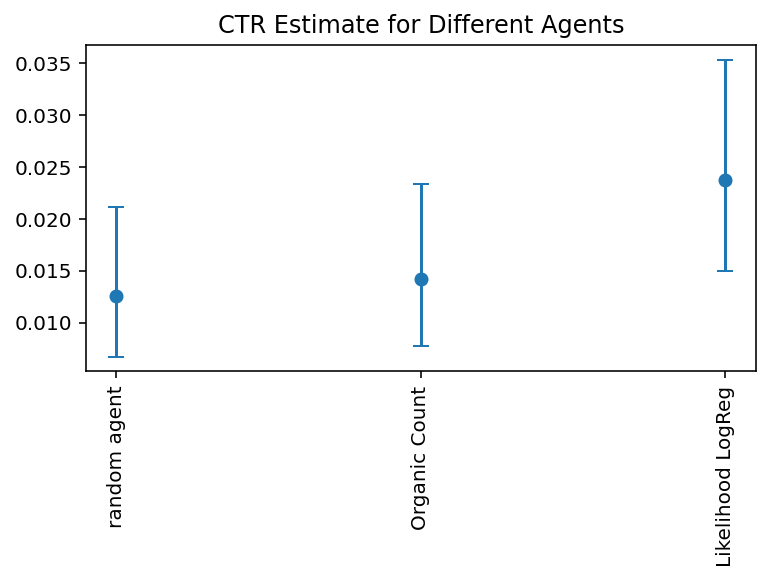

In [40]:
fig = plot_verify_agents(result)
plt.show()